## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import DataProcessor
import SRMSE
import VAE

## Choose Variables and Preprocess

In [2]:
# Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

# Filter to desired variables (numeric then categorical)
pums_data_h = h_df[['SERIALNO','HINCP','NP','VEH','BLD','ACCESS']]
pums_data_p = p_df[['SERIALNO','PWGTP','PINCP','AGEP','JWMNP','SEX','SCHL','MAR','COW','DPHY','DEYE','DREM','RAC1P']]
del h_df
del p_df
pums_data = pd.merge(pums_data_p, pums_data_h, on='SERIALNO')
pums_data = pums_data.drop(labels=['SERIALNO'], axis=1)

# Convert numerical variables to categorical bins
pums_data['HINCP'], hincp_bins = pd.qcut(pums_data['HINCP'], q=10, labels=False, retbins=True)
pums_data['AGEP'], agep_bins = pd.qcut(pums_data['AGEP'], q=10, labels=False, retbins=True)
pums_data['JWMNP'], jwmnp_bins = pd.qcut(pums_data['JWMNP'], q=10, labels=False, retbins=True)
pums_data['PINCP'], pincp_bins = pd.qcut(pums_data['PINCP'], q=10, labels=False, retbins=True)


# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

# Scale by the person-weights to get true population
pums_data = pums_data.reindex(pums_data.index.repeat(pums_data['PWGTP']))
pums_data = pums_data.drop('PWGTP', axis=1)
pums_data_p = pums_data_p.drop('PWGTP', axis=1)
np.random.seed(420)
pums_data = pums_data.sample(150000)
pums_data

Dataset n=359075 pre-cleaning
Dataset n=150203 post-cleaning


,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS
124097,8.0,4,4.0,1,20.0,5,2.0,2.0,2,2.0,1,5.0,1,1.0,2.0,1.0
213970,6.0,7,2.0,1,18.0,3,1.0,2.0,2,2.0,1,2.0,2,3.0,1.0,1.0
244109,9.0,5,4.0,1,21.0,1,1.0,2.0,2,2.0,1,7.0,4,2.0,2.0,1.0
203719,8.0,5,9.0,2,21.0,2,2.0,2.0,2,2.0,9,4.0,1,1.0,3.0,1.0
118501,1.0,6,5.0,2,15.0,2,2.0,2.0,2,2.0,1,0.0,1,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145574,6.0,2,1.0,1,21.0,1,1.0,2.0,2,2.0,1,5.0,2,2.0,7.0,1.0
141400,3.0,3,2.0,2,16.0,5,1.0,2.0,2,2.0,3,0.0,3,1.0,2.0,1.0
180818,5.0,6,1.0,2,16.0,3,2.0,2.0,2,2.0,2,1.0,1,2.0,6.0,2.0
354161,7.0,4,0.0,1,16.0,1,1.0,2.0,2,2.0,1,7.0,3,4.0,2.0,1.0


In [3]:
HH_IDX = pums_data_p.shape[1] - 1  # Index of household variables start
VAR_DIM = pums_data.shape[1]  # Length of all variables before OHE
VAR_NAMES = pums_data.columns  # Names of all variables before OHE
HH_VAR_NAMES = pums_data_h.columns  # Names of the hh variables

del pums_data_p
del pums_data_h

# Split categorical data into OHE vars, save num classes per variable, as well as numeric encodings per variable
dummies_list = []
pums_encodings_list = []
for x in range(VAR_DIM):
    dummies = pums_data.iloc[:,x]
    pums_encodings_list.append(np.unique(dummies.values))
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
    del dummies
CAT_LENGTHS = [x.shape[1] for x in dummies_list]
print(f"Categorical variable class lengths: {CAT_LENGTHS}")

Categorical variable class lengths: [10, 9, 10, 2, 24, 5, 8, 2, 2, 2, 9, 10, 18, 7, 10, 3]


In [4]:
# Final data frame after encoding OHE
model_data_df = pd.DataFrame()
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
del ohe_var
MANIFEST_DIM = model_data_df.shape[1]
HH_IDX_MANIFEST = sum(CAT_LENGTHS[:HH_IDX])

# Add columns for original household variables; these will be used as conditionals
# model_data_df = pd.concat([model_data_df, model_data_df.iloc[:,HH_IDX_MANIFEST:]], axis=1)

# Preview data that will be fed into model
model_data_df

,PINCP__0.0,PINCP__1.0,PINCP__2.0,PINCP__3.0,PINCP__4.0,PINCP__5.0,PINCP__6.0,PINCP__7.0,PINCP__8.0,PINCP__9.0,...,BLD__4.0,BLD__5.0,BLD__6.0,BLD__7.0,BLD__8.0,BLD__9.0,BLD__10.0,ACCESS__1.0,ACCESS__2.0,ACCESS__3.0
124097,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
213970,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
244109,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
203719,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
118501,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145574,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
141400,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
180818,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
354161,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# Separate into train/test data
model_data = model_data_df.values
train_idx = round(len(model_data)*.7)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

print(f"Training on {train_idx} samples")

Training on 105000 samples


## Set Parameters and Define Model

In [6]:
# Grid Search SRMSE 1
# BATCH_SIZES = [64, 128, 256, 512, 1024]
# EPOCHS = [1000]
# LATENT_DIMS = [4, 6, 8]
# HIDDEN_DIMS = [8, 16, 32, 64]
# KL_WEIGHTS = [.01, .05, .1, 1.0]
# [313.08608531951904, 11.0505690574646, 0.02598349649036663, 0.006970305382407434, [512, 1000, 6, 64, 0.1]]
# [290.68157863616943, 6.595394611358643, 0.026173123522601732, 0.00692727365319053, [256, 1000, 6, 64, 0.1]]
# [99.60163021087646, 6.652237892150879, 0.028944710845045213, 0.0071278053533916155, [1024, 1000, 8, 16, 0.05]]

# Hyperparameters
BATCH_SIZE = 1024
EPOCHS = 1000
LATENT_DIM = 8
HIDDEN_DIM = 16
KL_WEIGHT = .05

## Training

In [7]:
val_loss = []
val_epochs = []
class validationCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            val_epochs.append(epoch)
            # Use random sample of 1000 from test data to validate the model
            idx = np.random.randint(test_data.shape[0], size=1000)
            val_data = test_data[idx]
            results = vae.predict(val_data)
            loss_cat = VAE.get_reconstruction_loss(val_data, results, CAT_LENGTHS)
            val_loss.append(loss_cat)

In [8]:
# # Load in the synthetic households
# synth_hh_df = pd.read_csv('data/synthetic_populations/wa_households.csv')
# synth_hh_ohe_df = pd.read_csv('data/synthetic_populations/wa_households_raw.csv')

# # Multiply the inputs by the number of persons per household (hh of size 3 becomes 3 rows with same scaled hh inputs)
# synth_hh_df['HH_ID'] = synth_hh_df.index
# synth_hh_ohe_df = synth_hh_ohe_df.reindex(synth_hh_ohe_df.index.repeat(synth_hh_df['NP']))
# synth_hh_df = synth_hh_df.reindex(synth_hh_df.index.repeat(synth_hh_df['NP']))

def testModel(test_vae, latent_dim):
    # How many synthetic households to fill
    POP_SIZE = len(synth_hh_ohe_df)

    # Generate random normal sample to represent each latent variable, for each row (different person per row)
    np.random.seed(42)
    epsilon = np.random.normal(loc=0, scale=1, size=(POP_SIZE, latent_dim))

    start_time = time.time()
    # Generate persons; each person has unique latent input, plus shared hh inputs with their household
    results = vae.decoder.predict([epsilon, synth_hh_ohe_df.values])
    gen_time = time.time() - start_time

    # Convert the test results from logits to values
    synth_p_df = pd.DataFrame()
    for i, x in enumerate(results[0]):
        result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
        result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
        synth_p_df = pd.concat([synth_p_df, result_df], axis=1)
    synth_p_df.columns = VAR_NAMES

    # Assign the control variables from the synthetic households to individuals (replace what came from the model)
    for var in HH_VAR_NAMES[1:]:
        synth_p_df[f"{var}"] = synth_hh_df[f"{var}"].values

    srmse_uni = SRMSE.calculateSRMSE(synth_p_df, pums_data.sample(POP_SIZE, replace=True, random_state=42))
    srmse_bi = SRMSE.calculateBivariateSRMSE(synth_p_df, pums_data.sample(POP_SIZE, replace=True, random_state=42))

    return gen_time, srmse_uni, srmse_bi

In [9]:
# # Use grid search to train model and get results for many different hyperparameters
# grid_search_results = []
# for bs in BATCH_SIZES:
#     for e in EPOCHS:
#         for ld in LATENT_DIMS:
#             for hd in HIDDEN_DIMS:
#                 for klw in KL_WEIGHTS:
#                     print(f"[{bs}, {e}, {ld}, {hd}, {klw}]")
#                     start_time = time.time()
#                     vae = VAE.VAE(MANIFEST_DIM, hd, ld, CAT_LENGTHS, HH_IDX, klw)
#                     vae.compile(optimizer=keras.optimizers.Adam())
#                     history = vae.fit(train_data, epochs=e, batch_size=bs, callbacks=[validationCallback()], verbose=0)
#                     train_time = (time.time()-start_time)
#                     gen_time, srmse_uni, srmse_bi = testModel(test_vae=vae, latent_dim=ld)
#                     results = [train_time, gen_time, srmse_uni, srmse_bi, [bs,e,ld,hd,klw]]
#                     grid_search_results.append(results)

# # Find the best results for each metric in the grid search
# min_srmse_uni_idx = 0
# min_srmse_uni_value = 999999999
# min_srmse_bi_idx = 0
# min_srmse_bi_value = 999999999
# min_eff_idx = 0
# min_eff_value = 999999999
# for i, result in enumerate(grid_search_results):
#     tot_time = result[0]+result[1]
#     time_eff = (result[2]+result[3] / 2) * tot_time
#     if result[2] < min_srmse_uni_value:
#         min_srmse_uni_idx = i
#         min_srmse_uni_value = result[2]
#     if result[3] < min_srmse_bi_value:
#         min_srmse_bi_idx = i
#         min_srmse_bi_value = result[3]
#     if time_eff < min_eff_value:
#         min_eff_idx = i
#         min_eff_value = time_eff

# # Display the results
# print(grid_search_results[min_srmse_uni_idx])
# print(grid_search_results[min_srmse_bi_idx])
# print(grid_search_results[min_eff_idx])

In [24]:
# For testing as a VAE rather than CVAE
HH_IDX = len(CAT_LENGTHS)
HH_IDX

16

In [25]:
# Train the model using single set of hyperparameters
start_time = time.time()
vae = VAE.VAE(MANIFEST_DIM, HIDDEN_DIM, LATENT_DIM, CAT_LENGTHS, HH_IDX, KL_WEIGHT)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[validationCallback()])
print(f"--- {time.time() - start_time} seconds ---")

Epoch 1/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 24.3021 - rec_loss: 23.9955 - kl_loss: 0.3066
Epoch 2/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 19.8121 - rec_loss: 19.5243 - kl_loss: 0.2878
Epoch 3/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 19.1082 - rec_loss: 18.8278 - kl_loss: 0.2804
Epoch 4/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 18.2760 - rec_loss: 17.9501 - kl_loss: 0.3259
Epoch 5/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 17.2898 - rec_loss: 16.8598 - kl_loss: 0.4300
Epoch 6/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 16.4904 - rec_loss: 15.9941 - kl_loss: 0.4962
Epoch 7/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 15.8557 - rec_loss: 15.3084 - kl_loss: 0.5473
Epoch 8/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 15.2846 - rec_loss: 14.6917 - kl_loss:

103/103 [==============================] - 1s 9ms/step - tot_loss: 9.9629 - rec_loss: 9.0467 - kl_loss: 0.9163
Epoch 66/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 9.9300 - rec_loss: 9.0126 - kl_loss: 0.9174
Epoch 67/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 9.8980 - rec_loss: 8.9785 - kl_loss: 0.9194
Epoch 68/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 9.8656 - rec_loss: 8.9434 - kl_loss: 0.9222
Epoch 69/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 9.8355 - rec_loss: 8.9121 - kl_loss: 0.9234
Epoch 70/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 9.8057 - rec_loss: 8.8795 - kl_loss: 0.9261
Epoch 71/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 9.7789 - rec_loss: 8.8508 - kl_loss: 0.9281
Epoch 72/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 9.7483 - rec_loss: 8.8178 - kl_loss: 0.9305
Epoch 73/1000


103/103 [==============================] - 1s 7ms/step - tot_loss: 8.5974 - rec_loss: 7.5866 - kl_loss: 1.0107
Epoch 131/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 8.5825 - rec_loss: 7.5717 - kl_loss: 1.0108
Epoch 132/1000
103/103 [==============================] - 1s 5ms/step - tot_loss: 8.5705 - rec_loss: 7.5566 - kl_loss: 1.0139
Epoch 133/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 8.5540 - rec_loss: 7.5400 - kl_loss: 1.0140
Epoch 134/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 8.5410 - rec_loss: 7.5266 - kl_loss: 1.0144
Epoch 135/1000
103/103 [==============================] - 1s 5ms/step - tot_loss: 8.5250 - rec_loss: 7.5100 - kl_loss: 1.0150
Epoch 136/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 8.5133 - rec_loss: 7.4974 - kl_loss: 1.0158
Epoch 137/1000
103/103 [==============================] - 1s 5ms/step - tot_loss: 8.4982 - rec_loss: 7.4813 - kl_loss: 1.0169
Epoch 1

103/103 [==============================] - 1s 8ms/step - tot_loss: 7.7736 - rec_loss: 6.7184 - kl_loss: 1.0552
Epoch 196/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 7.7630 - rec_loss: 6.7077 - kl_loss: 1.0553
Epoch 197/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 7.7502 - rec_loss: 6.6945 - kl_loss: 1.0558
Epoch 198/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 7.7413 - rec_loss: 6.6857 - kl_loss: 1.0557
Epoch 199/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 7.7306 - rec_loss: 6.6735 - kl_loss: 1.0570
Epoch 200/1000
103/103 [==============================] - 1s 14ms/step - tot_loss: 7.7191 - rec_loss: 6.6620 - kl_loss: 1.0571
Epoch 201/1000
103/103 [==============================] - 2s 17ms/step - tot_loss: 7.7090 - rec_loss: 6.6510 - kl_loss: 1.0580
Epoch 202/1000
103/103 [==============================] - 2s 15ms/step - tot_loss: 7.6963 - rec_loss: 6.6382 - kl_loss: 1.0581
Epoc

103/103 [==============================] - 1s 7ms/step - tot_loss: 7.1876 - rec_loss: 6.1128 - kl_loss: 1.0748
Epoch 261/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 7.1821 - rec_loss: 6.1064 - kl_loss: 1.0757
Epoch 262/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 7.1767 - rec_loss: 6.1016 - kl_loss: 1.0751
Epoch 263/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 7.1688 - rec_loss: 6.0930 - kl_loss: 1.0758
Epoch 264/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 7.1597 - rec_loss: 6.0845 - kl_loss: 1.0752
Epoch 265/1000
103/103 [==============================] - 1s 10ms/step - tot_loss: 7.1576 - rec_loss: 6.0819 - kl_loss: 1.0757
Epoch 266/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 7.1505 - rec_loss: 6.0742 - kl_loss: 1.0762
Epoch 267/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 7.1449 - rec_loss: 6.0685 - kl_loss: 1.0764
Epoch 

103/103 [==============================] - 1s 7ms/step - tot_loss: 6.8483 - rec_loss: 5.7682 - kl_loss: 1.0801
Epoch 326/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 6.8426 - rec_loss: 5.7624 - kl_loss: 1.0803
Epoch 327/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 6.8388 - rec_loss: 5.7587 - kl_loss: 1.0801
Epoch 328/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 6.8355 - rec_loss: 5.7555 - kl_loss: 1.0800
Epoch 329/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 6.8320 - rec_loss: 5.7521 - kl_loss: 1.0798
Epoch 330/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 6.8270 - rec_loss: 5.7467 - kl_loss: 1.0803
Epoch 331/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.8210 - rec_loss: 5.7410 - kl_loss: 1.0801
Epoch 332/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.8160 - rec_loss: 5.7368 - kl_loss: 1.0793
Epoch 3

103/103 [==============================] - 1s 9ms/step - tot_loss: 6.6068 - rec_loss: 5.5226 - kl_loss: 1.0843
Epoch 391/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 6.6050 - rec_loss: 5.5198 - kl_loss: 1.0851
Epoch 392/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.6004 - rec_loss: 5.5154 - kl_loss: 1.0850
Epoch 393/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.5960 - rec_loss: 5.5109 - kl_loss: 1.0851
Epoch 394/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.5931 - rec_loss: 5.5075 - kl_loss: 1.0856
Epoch 395/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 6.5896 - rec_loss: 5.5041 - kl_loss: 1.0855
Epoch 396/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 6.5849 - rec_loss: 5.4992 - kl_loss: 1.0856
Epoch 397/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 6.5815 - rec_loss: 5.4962 - kl_loss: 1.0854
Epoch 3

103/103 [==============================] - 1s 7ms/step - tot_loss: 6.3500 - rec_loss: 5.2518 - kl_loss: 1.0982
Epoch 456/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.3457 - rec_loss: 5.2472 - kl_loss: 1.0985
Epoch 457/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.3415 - rec_loss: 5.2424 - kl_loss: 1.0991
Epoch 458/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 6.3384 - rec_loss: 5.2387 - kl_loss: 1.0997
Epoch 459/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 6.3356 - rec_loss: 5.2350 - kl_loss: 1.1006
Epoch 460/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.3298 - rec_loss: 5.2301 - kl_loss: 1.0996
Epoch 461/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.3234 - rec_loss: 5.2241 - kl_loss: 1.0993
Epoch 462/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.3212 - rec_loss: 5.2203 - kl_loss: 1.1010
Epoch 4

103/103 [==============================] - 1s 7ms/step - tot_loss: 6.0980 - rec_loss: 4.9838 - kl_loss: 1.1142
Epoch 521/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 6.0929 - rec_loss: 4.9780 - kl_loss: 1.1149
Epoch 522/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.0901 - rec_loss: 4.9756 - kl_loss: 1.1144
Epoch 523/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.0890 - rec_loss: 4.9746 - kl_loss: 1.1144
Epoch 524/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.0806 - rec_loss: 4.9668 - kl_loss: 1.1138
Epoch 525/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.0781 - rec_loss: 4.9648 - kl_loss: 1.1134
Epoch 526/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.0803 - rec_loss: 4.9662 - kl_loss: 1.1140
Epoch 527/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.0745 - rec_loss: 4.9589 - kl_loss: 1.1156
Epoch 5

103/103 [==============================] - 1s 8ms/step - tot_loss: 5.9329 - rec_loss: 4.8115 - kl_loss: 1.1214
Epoch 586/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.9301 - rec_loss: 4.8073 - kl_loss: 1.1228
Epoch 587/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 5.9259 - rec_loss: 4.8045 - kl_loss: 1.1214
Epoch 588/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 5.9245 - rec_loss: 4.8017 - kl_loss: 1.1228
Epoch 589/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 5.9270 - rec_loss: 4.8040 - kl_loss: 1.1229
Epoch 590/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 5.9223 - rec_loss: 4.7996 - kl_loss: 1.1228
Epoch 591/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 5.9215 - rec_loss: 4.7990 - kl_loss: 1.1225
Epoch 592/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 5.9136 - rec_loss: 4.7914 - kl_loss: 1.1222
Epoch 5

103/103 [==============================] - 1s 6ms/step - tot_loss: 5.8034 - rec_loss: 4.6770 - kl_loss: 1.1265
Epoch 651/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.8079 - rec_loss: 4.6806 - kl_loss: 1.1273
Epoch 652/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.8013 - rec_loss: 4.6749 - kl_loss: 1.1263
Epoch 653/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.7983 - rec_loss: 4.6722 - kl_loss: 1.1262
Epoch 654/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.7947 - rec_loss: 4.6693 - kl_loss: 1.1254
Epoch 655/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.7927 - rec_loss: 4.6664 - kl_loss: 1.1263
Epoch 656/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 5.7959 - rec_loss: 4.6688 - kl_loss: 1.1271
Epoch 657/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.7926 - rec_loss: 4.6663 - kl_loss: 1.1263
Epoch 6

103/103 [==============================] - 1s 7ms/step - tot_loss: 5.7135 - rec_loss: 4.5831 - kl_loss: 1.1304
Epoch 716/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.7067 - rec_loss: 4.5774 - kl_loss: 1.1293
Epoch 717/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.7057 - rec_loss: 4.5750 - kl_loss: 1.1307
Epoch 718/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.7071 - rec_loss: 4.5762 - kl_loss: 1.1309
Epoch 719/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.7089 - rec_loss: 4.5789 - kl_loss: 1.1300
Epoch 720/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.7013 - rec_loss: 4.5713 - kl_loss: 1.1301
Epoch 721/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 5.7033 - rec_loss: 4.5731 - kl_loss: 1.1302
Epoch 722/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.7045 - rec_loss: 4.5738 - kl_loss: 1.1306
Epoch 7

103/103 [==============================] - 1s 8ms/step - tot_loss: 5.6354 - rec_loss: 4.5002 - kl_loss: 1.1352
Epoch 781/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 5.6312 - rec_loss: 4.4967 - kl_loss: 1.1345
Epoch 782/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.6305 - rec_loss: 4.4967 - kl_loss: 1.1338
Epoch 783/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.6267 - rec_loss: 4.4925 - kl_loss: 1.1342
Epoch 784/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 5.6274 - rec_loss: 4.4936 - kl_loss: 1.1338
Epoch 785/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 5.6303 - rec_loss: 4.4949 - kl_loss: 1.1354
Epoch 786/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.6307 - rec_loss: 4.4954 - kl_loss: 1.1352
Epoch 787/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.6266 - rec_loss: 4.4918 - kl_loss: 1.1349
Epoch 7

103/103 [==============================] - 1s 7ms/step - tot_loss: 5.5674 - rec_loss: 4.4300 - kl_loss: 1.1374
Epoch 846/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.5650 - rec_loss: 4.4270 - kl_loss: 1.1380
Epoch 847/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.5663 - rec_loss: 4.4277 - kl_loss: 1.1385
Epoch 848/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 5.5763 - rec_loss: 4.4370 - kl_loss: 1.1394
Epoch 849/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 5.5603 - rec_loss: 4.4238 - kl_loss: 1.1365
Epoch 850/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.5588 - rec_loss: 4.4223 - kl_loss: 1.1365
Epoch 851/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.5580 - rec_loss: 4.4216 - kl_loss: 1.1364
Epoch 852/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.5581 - rec_loss: 4.4209 - kl_loss: 1.1372
Epoch 8

103/103 [==============================] - 1s 9ms/step - tot_loss: 5.4850 - rec_loss: 4.3488 - kl_loss: 1.1362
Epoch 911/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 5.4869 - rec_loss: 4.3495 - kl_loss: 1.1374
Epoch 912/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.4845 - rec_loss: 4.3477 - kl_loss: 1.1368
Epoch 913/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 5.4840 - rec_loss: 4.3463 - kl_loss: 1.1377
Epoch 914/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 5.4833 - rec_loss: 4.3466 - kl_loss: 1.1368
Epoch 915/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.4808 - rec_loss: 4.3435 - kl_loss: 1.1372
Epoch 916/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 5.4780 - rec_loss: 4.3406 - kl_loss: 1.1373
Epoch 917/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 5.4746 - rec_loss: 4.3376 - kl_loss: 1.1370
Epoch 9

103/103 [==============================] - 1s 10ms/step - tot_loss: 5.4108 - rec_loss: 4.2714 - kl_loss: 1.1394
Epoch 976/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.4070 - rec_loss: 4.2667 - kl_loss: 1.1403
Epoch 977/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 5.4033 - rec_loss: 4.2632 - kl_loss: 1.1402
Epoch 978/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 5.4034 - rec_loss: 4.2627 - kl_loss: 1.1406
Epoch 979/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 5.4013 - rec_loss: 4.2610 - kl_loss: 1.1403
Epoch 980/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 5.4029 - rec_loss: 4.2620 - kl_loss: 1.1409
Epoch 981/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 5.4021 - rec_loss: 4.2619 - kl_loss: 1.1401
Epoch 982/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.4020 - rec_loss: 4.2613 - kl_loss: 1.1406
Epoch 

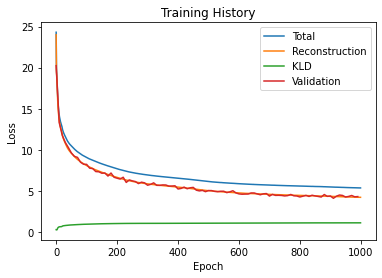

In [26]:
# Plot model loss/training progress
plt.plot(history.history['tot_loss'])
plt.plot(history.history['rec_loss'])
plt.plot(history.history['kl_loss'])
plt.plot(val_epochs, val_loss)
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Total","Reconstruction","KLD","Validation"], loc="upper right")
plt.show()

## Testing

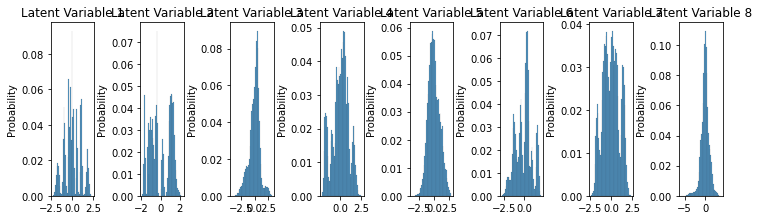

In [27]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=1, ncols=LATENT_DIM, figsize=(10,3))
fig.tight_layout(w_pad=2, h_pad=10)

for i in range(LATENT_DIM):
    sns.histplot(z[:,i], ax=axes[i], bins=50, stat="probability")
    axes[i].set_title(f"Latent Variable {i+1}")

In [28]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_cat = VAE.get_reconstruction_loss(test_data, results, CAT_LENGTHS)
print(f"Categorical Variable Loss: {loss_cat}")

Categorical Variable Loss: 4.234889030456543


In [29]:
# Convert the testing data from ohe to values
test_data_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_data_df = pd.concat([test_data_df, result_df], axis=1)
test_data_df.columns = VAR_NAMES

# Convert the test results from logits to values
test_results_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_results_df = pd.concat([test_results_df, result_df], axis=1)
test_results_df.columns = VAR_NAMES

## Generating Synthetic Population

In [30]:
# Load in the synthetic households
synth_hh_df = pd.read_csv('data/synthetic_populations/wa_households.csv')
synth_hh_ohe_df = pd.read_csv('data/synthetic_populations/wa_households_raw.csv')

# How many variables represent each household
HH_DIM = 5

In [31]:
# Multiply the inputs by the number of persons per household (hh of size 3 becomes 3 rows with same scaled hh inputs)
synth_hh_df['HH_ID'] = synth_hh_df.index
synth_hh_ohe_df = synth_hh_ohe_df.reindex(synth_hh_ohe_df.index.repeat(synth_hh_df['NP']))
synth_hh_df = synth_hh_df.reindex(synth_hh_df.index.repeat(synth_hh_df['NP']))

# How many synthetic households to fill
POP_SIZE = len(synth_hh_ohe_df)
print(POP_SIZE)

268705


In [ ]:
# Generate random normal sample to represent each latent variable, for each row (different person per row)
epsilon = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

# Load the most recently trained model
# vae = keras.models.load_model('person_synthesizer')

start_time = time.time()

# Generate persons; each person has unique latent input, plus shared hh inputs with their household
# results = vae.decoder.predict([epsilon, synth_hh_ohe_df.values])
results = vae.decoder.predict([epsilon, epsilon[:,LATENT_DIM:]])  # Nothing is actually in the second input

print(f"--- {time.time() - start_time} seconds ---")

del epsilon

# Convert the test results from logits to values
synth_p_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    synth_p_df = pd.concat([synth_p_df, result_df], axis=1)
synth_p_df.columns = VAR_NAMES

# Assign the control variables from the synthetic households to individuals (replace what came from the model)
# for var in HH_VAR_NAMES[1:]:
#     synth_p_df[f"{var}"] = synth_hh_df[f"{var}"].values

# Save the synthesized persons
synth_p_df.to_csv('data/synthetic_populations/wa_persons_100000_vae.csv', index=False)

--- 7.85249662399292 seconds ---


<ipython-input-18-370640e01e01>:3: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(h_pad=40)


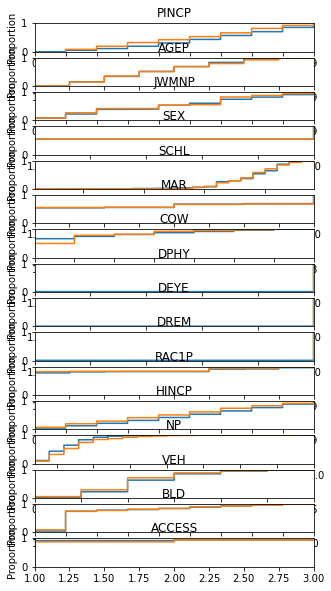

In [18]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=40)

for i, var in enumerate(VAR_NAMES):
    sns.ecdfplot(data=pums_data, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    sns.ecdfplot(data=synth_p_df, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)

In [19]:
testModel(test_vae=vae, latent_dim=LATENT_DIM)
# gen_time, srmse_uni, srmse_bi

Univariate (marginal) SRMSE: 0.2964504531180633, Total Bins: 131
Bivariate (joint) SRMSE: 0.846157263640871, Total Bins: 7768


(13.81206750869751, 0.2964504531180633, 0.846157263640871)